In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.logistic_regression import log_loss_ridge, import_breast_cancer, accuracy_func, logistic_loss_func, logistic_grad, ridge_term
from Code.utilities import train_test_split, plot_test_results
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import jax.numpy as jnp
import numpy as np
from jax import nn, grad, jit, pmap

In [2]:
X, y = import_breast_cancer()
X = jnp.array(X)
y = jnp.array(y)


c:\Users\Eirik\Desktop\UIO\FYSSTK\Project2_FYS_STK4155\Code\logistic_regression.py:47: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  X = jnp.array(data.to_numpy()[:, 1:-1], dtype=jnp.float64)


In [6]:
def single_run(X, y, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, test_index=None):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)

    epochs = 100

    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation, output_activation=nn.sigmoid))

    #loss_func = logistic_loss_func(model=model)


    loss_func = jit(log_loss_ridge(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    #print(loss_grad(beta0, X, y))


    test_func = jit(accuracy_func(model))

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)

    result.update({"test_index":test_index})

    #plot_test_results(result["test_loss_list"], result["train_loss_list"], 5)
    # result2 = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, batch_size=batch_size, test_loss_func=test_func, lr=lr)
    # plot_test_results(result2["test_loss_list"], result2["train_loss_list"], result["m"])


    return result





result = single_run(X, y, 0.0001, 0.000, hidden_layer_num=5, node_per_hidden=5, hidden_activation=nn.leaky_relu)
print("Log run")
#result = single_run(X, y, 0.01, 0.001, 0, 5, hidden_activation=nn.relu)



Log run


### Note for report

When initializing the parameters with only positive values we get a tendency that the initial output gets bigger and bigger the larger the model. This caused the model to predict 1 in all training examples(after sigmoid) and so the gradient became zero everywhere and the model got stuck. When initializing with negative and positive values we got more varied outputs and nonzero gradients and so the model managed to start learning.

In [7]:
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}

### Lambda Search

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

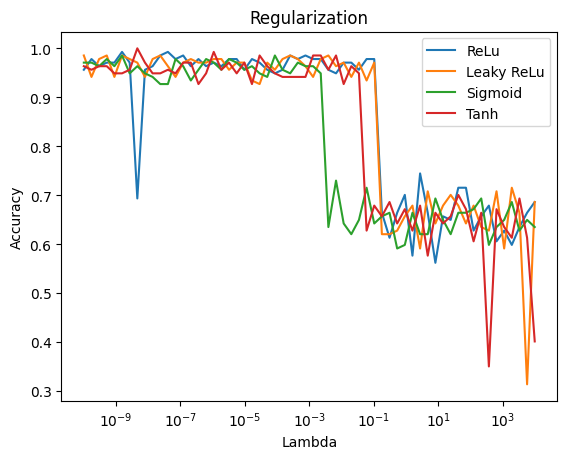

In [14]:
def search_lam(plot_or_not=False):
    lams = np.logspace(-10, 4, num=60)
    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lam in tqdm(lams):
            tqdm.write(f"Lambda: {lam}")
            result = single_run(X, y, lr=0.01, lam=lam, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])
        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lams, test_errs, label=act_func)

    plt.legend()
    #plt.plot(lams, train_errs)
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Lambda")
    plt.xscale("log")
    plt.show()

    return {"lams":lams, "test_error":test_errs, "train_error":train_errs}

experiment = search_lam()

### Learning Rate search

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

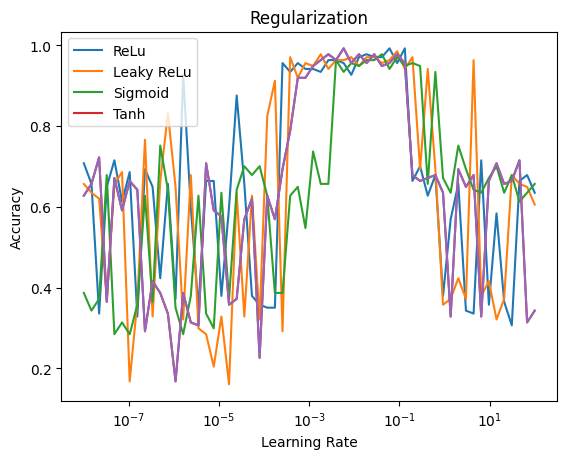

In [15]:

def search_lrs(plot_or_not=False):
    lrs = np.logspace(-8, 2, num=60)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lr in tqdm(lrs):
            tqdm.write(f"Learning rate: {lr}")
            result = single_run(X, y, lr=lr, lam=0.00, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lrs, test_errs, label=act_func)

    plt.plot(lrs, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Learning Rate")
    plt.xscale("log")
    plt.show()

    return {"lrs":lrs, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_lrs()

### Note for report

The place with learning rate lower than e-4 is the place where the model sometimes has low enough initial gradients that when multiplied with the learning rate is rounded to zero and so the model becomes stuck and does not learn. Hence we see bad performance and alot of random variance in the results in this region.

### Layer Size

  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


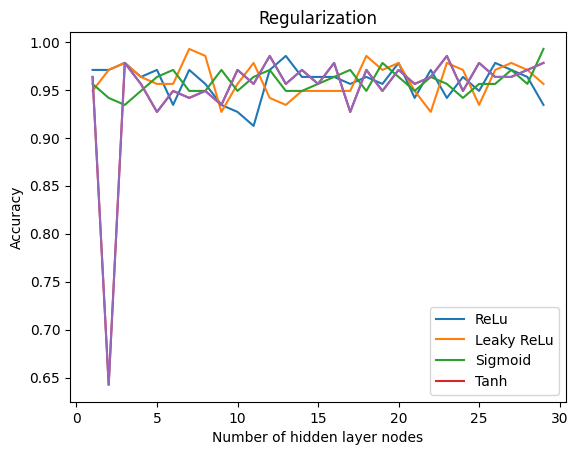

In [27]:

def search_hidden_layer_sizes(plot_or_not=False):
    hidden_layer_sizes = np.arange(1, 30)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_size in tqdm(hidden_layer_sizes):
            tqdm.write(f"Hidden Layer size: {hidden_layer_size}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=1, node_per_hidden=hidden_layer_size, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_sizes, test_errs, label=act_func)

    plt.plot(hidden_layer_sizes, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layer nodes")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_sizes, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_sizes()

  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


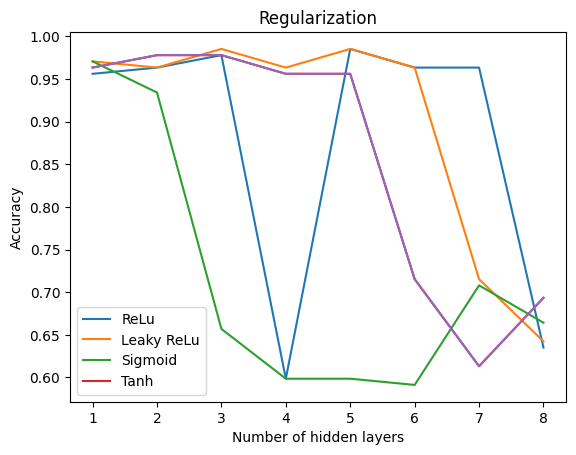

In [9]:

def search_hidden_layer_number(plot_or_not=False):
    hidden_layer_numbers = np.arange(1, 9)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_number in tqdm(hidden_layer_numbers):
            tqdm.write(f"Hidden Layer number: {hidden_layer_number}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=hidden_layer_number, node_per_hidden=5, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_numbers, test_errs, label=act_func)

    plt.plot(hidden_layer_numbers, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layers")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_number()